In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta

In [59]:
def light_curve(low_path: str, high_path: str, unique_ids: list = None, plot: bool = True, table: bool = True):

    low_df = pd.read_csv(low_path)
    high_df = pd.read_csv(high_path)
    if unique_ids == None:
        unique_ids = high_df['Source ID'].tolist()

    if plot:
        for source in unique_ids:
            plt.subplots()
            source_df = low_df[low_df['Source ID'] == source]
            fluxes = source_df['Flux (mJy)'].to_list()
            flux_errs = source_df['Flux Uncert (mJy)'].to_list()
            flux_unit = 'mJy'
            if max(fluxes) > 1000:
                flux_unit = 'Jy'
                for i in range(len(fluxes)):
                    fluxes[i] /= 1000
                    flux_errs[i] /= 1000
            date_times = source_df['Obs Date Time'].tolist()
            for i in range(len(date_times)):
                dt = date_times[i]
                m_end = dt.rindex(':')
                s_start = m_end + 1
                if dt[s_start:] == '60':
                    dt = dt[:s_start] + '0'
                    fmt = '%m-%d-%y %H:%M'
                    date_times[i] = (datetime.strptime(dt[:m_end], fmt) + timedelta(minutes=1)).strftime('%m-%d-%y %H:%M:%S')

            fmt_str = '%m-%d-%y %H:%M:%S'
            date_times = [Time(datetime.strptime(dt, fmt_str), format='datetime', scale='utc').mjd for dt in date_times]

            freqs = source_df['Freq (GHz)'].tolist()
            other = []
            small_milli = [] # 1.1mm
            large_milli = [] # 1.3mm
            micro = [] # 870µm
            for i in range(len(freqs)):
                if freqs[i] == 'Not found':
                    other.append(i)
                    pass
                else:
                    try:
                        if freqs[i] > 260.69 and freqs[i] < 285.52: # 1.15-1.05mm
                            small_milli.append(i)
                        elif freqs[i] > 222.07 and freqs[i] < 239.83: # 1.35-1.25mm
                            large_milli.append(i)
                        elif freqs[i] > 340.67 and freqs[i] < 348.60: # 880-860µm
                            micro.append(i)
                        else:
                            other.append(i)
                    except Exception as e:
                        print(f'Error while getting the frequencies for source {source}: {e}')
            other_dt = [date_times[a] for a in other]
            other_flx = [fluxes[a] for a in other]
            other_flx_err = [flux_errs[a] for a in other]
            sm_milli_dt = [date_times[b] for b in small_milli]
            sm_milli_flx = [fluxes[b] for b in small_milli]
            sm_milli_flx_err = [flux_errs[b] for b in small_milli]
            lg_milli_dt = [date_times[c] for c in large_milli]
            lg_milli_flx = [fluxes[c] for c in large_milli]
            lg_milli_flx_err = [flux_errs[c] for c in large_milli]
            micro_dt = [date_times[d] for d in micro]
            micro_flx = [fluxes[d] for d in micro]
            micro_flx_err = [flux_errs[d] for d in micro]

            plt.errorbar(sm_milli_dt, sm_milli_flx, yerr=sm_milli_flx_err, color='g', fmt='x', capsize=3, markersize=2,\
                        capthick=0.5, elinewidth=0.5, label='1.1mm')
            plt.errorbar(lg_milli_dt, lg_milli_flx, yerr=lg_milli_flx_err, color='r', fmt='x', capsize=3, markersize=2,\
                        capthick=0.5, elinewidth=0.5, label='1.3mm')
            plt.errorbar(micro_dt, micro_flx, yerr=micro_flx_err, color='b', fmt='x', capsize=3, markersize=2,\
                        capthick=0.5, elinewidth=0.5, label='870µm')
            plt.errorbar(other_dt, other_flx, yerr=other_flx_err, color='k', fmt='x', capsize=3, markersize=2,\
                        capthick=0.5, elinewidth=0.5, label='Other/not found')

            plt.title(f'Source {source[2:]}')
            plt.xlabel('Modified Julian Date')
            plt.ylabel(f'Flux [{flux_unit}]')
            plt.legend()
            plt.ylim(bottom=0)

    if table:
        for j in range(len(unique_ids)):
            source = unique_ids[j]
            source_df = low_df[low_df['Source ID'] == source]
            dat_name = f'./{source}_flux_history.dat'
            with open(dat_name, 'w') as new_file:
                new_file.write('#{}, RA: {}, Dec:{}\n'.format(source, high_df.loc[j, 'RA'], low_df.loc[j, 'Dec']))
            cal_df = source_df.copy()
            for col in cal_df.columns:
                if col not in ['Obs Date Time', 'Obs ID', 'Flux (mJy)', 'Flux Uncert (mJy)']:
                    cal_df.drop(columns=col, inplace=True)
            snr_list = [round(float(cal_df['Flux (mJy)'].to_list()[i] / cal_df['Flux Uncert (mJy)'].to_list()[i]), 2) for i in range(len(cal_df))]
            cal_df['SNR'] = snr_list
            fmt_str = '%m-%d-%y %H:%M:%S'
            mjd_list = [float(Time(datetime.strptime(dt, fmt_str), format='datetime', scale='utc').mjd) for dt in cal_df['Obs Date Time']]
            cal_df['MJD'] = mjd_list
            cal_df.to_csv(dat_name, sep='\t', index=False, mode='a')

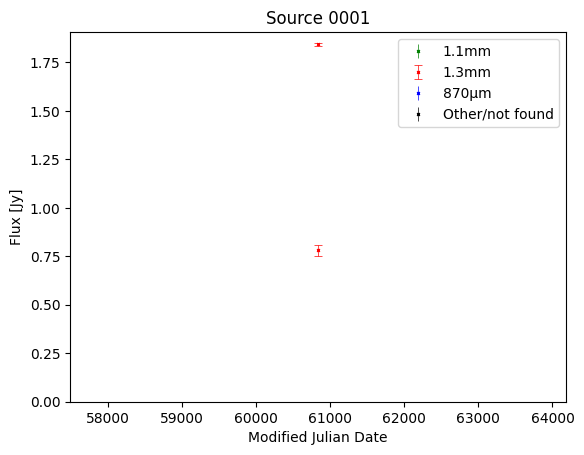

In [60]:
light_curve('./test_low.csv', './test_high.csv', unique_ids=['id0001'])

In [ ]:
plt.plot()

##### M. Gurwell data #####
df = pd.read_table('../flux_history/SMA_fluxhistory/2253+161_smafh.dat', comment='!', header=None, skipinitialspace=True,\
                    sep=r'[\+/\- ]+',\
                    names=('Band', 'Day', 'Month', 'Year', 'Time', 'Obs', 'Freq (GHz)', 'Flux (Jy)', 'Error (Jy)', 'SNR', 'PI', 'MJD'))

fluxes = df['Flux (Jy)'].tolist()
flux_errs = df['Error (Jy)'].tolist()
date_times = df['MJD'].tolist()

band = df['Band'].tolist()
other = []
small_milli = [] # 1.1mm
large_milli = [] # 1.3mm
micro = [] # 870 µm
for i in range(len(band)):
    if band[i] == '870mi':
        micro.append(i)
    elif band[i] == '1.1mm':
        small_milli.append(i)
    elif band[i] == '1.3mm':
        large_milli.append(i)
    else:
        other.append(i)

other_dt = [date_times[a] for a in other]
other_flx = [fluxes[a] for a in other]
other_flx_err = [flux_errs[a] for a in other]
sm_milli_dt = [date_times[b] for b in small_milli]
sm_milli_flx = [fluxes[b] for b in small_milli]
sm_milli_flx_err = [flux_errs[b] for b in small_milli]
lg_milli_dt = [date_times[c] for c in large_milli]
lg_milli_flx = [fluxes[c] for c in large_milli]
lg_milli_flx_err = [flux_errs[c] for c in large_milli]
micro_dt = [date_times[d] for d in micro]
micro_flx = [fluxes[d] for d in micro]
micro_flx_err = [flux_errs[d] for d in micro]

plt.errorbar(sm_milli_dt, sm_milli_flx, yerr=sm_milli_flx_err, color='g', fmt='o', capsize=3, markersize=2,\
            capthick=0.5, elinewidth=0.5, label='1.1mm M. Gurwell')
plt.errorbar(lg_milli_dt, lg_milli_flx, yerr=lg_milli_flx_err, color='r', fmt='o', capsize=3, markersize=2,\
            capthick=0.5, elinewidth=0.5, label='1.3mm M. Gurwell')
plt.errorbar(micro_dt, micro_flx, yerr=micro_flx_err, color='b', fmt='o', capsize=3, markersize=2,\
            capthick=0.5, elinewidth=0.5, label='870µm M. Gurwell')
plt.errorbar(other_dt, other_flx, yerr=other_flx_err, color='k', fmt='o', capsize=3, markersize=2,\
            capthick=0.5, elinewidth=0.5, label='Other/not found M. Gurwell')

##### archive data #####
low_df = pd.read_csv('./low_level.csv')

source_df = low_df[low_df['Source ID'] == 'id0015']
fluxes = source_df['Flux Density']
fluxes = [float(flux.replace('mJy', '')) for flux in fluxes]
flux_errs = source_df['Flux Uncert']
flux_errs = [float(err.replace('mJy', '')) for err in flux_errs]
flux_unit = 'mJy'
if max(fluxes) > 1000:
    flux_unit = 'Jy'
    for i in range(len(fluxes)):
        fluxes[i] /= 1000
        flux_errs[i] /= 1000
date_times = source_df['Obs Date Time'].tolist()
for i in range(len(date_times)):
    dt = date_times[i]
    m_end = dt.rindex(':')
    s_start = m_end + 1
    if dt[s_start:] == '60':
        dt = dt[:s_start] + '0'
        fmt = '%m-%d-%y %H:%M'
        date_times[i] = (datetime.strptime(dt[:m_end], fmt) + timedelta(minutes=1)).strftime('%m-%d-%y %H:%M:%S')

fmt_str = '%m-%d-%y %H:%M:%S'
date_times = [Time(datetime.strptime(dt, fmt_str), format='datetime', scale='utc').mjd for dt in date_times]

freqs = source_df['Freq'].tolist()
other = []
small_milli = [] # 1.1mm
large_milli = [] # 1.3mm
micro = [] # 870µm
for i in range(len(freqs)):
    if freqs[i] == 'Not found':
        other.append(i)
        pass
    else:
        try:
            freqs[i] = float(freqs[i].replace('GHz', ''))
            if freqs[i] > 260.69 and freqs[i] < 285.52: # 1.15-1.05mm
                small_milli.append(i)
            elif freqs[i] > 222.07 and freqs[i] < 239.83: # 1.35-1.25mm
                large_milli.append(i)
            elif freqs[i] > 340.67 and freqs[i] < 348.60: # 880-860µm
                micro.append(i)
            else:
                other.append(i)
        except Exception as e:
            print(f'Error while getting the frequencies for source: {e}')

other_dt = [date_times[a] for a in other]
other_flx = [fluxes[a] for a in other]
other_flx_err = [flux_errs[a] for a in other]
sm_milli_dt = [date_times[b] for b in small_milli]
sm_milli_flx = [fluxes[b] for b in small_milli]
sm_milli_flx_err = [flux_errs[b] for b in small_milli]
lg_milli_dt = [date_times[c] for c in large_milli]
lg_milli_flx = [fluxes[c] for c in large_milli]
lg_milli_flx_err = [flux_errs[c] for c in large_milli]
micro_dt = [date_times[d] for d in micro]
micro_flx = [fluxes[d] for d in micro]
micro_flx_err = [flux_errs[d] for d in micro]

plt.errorbar(sm_milli_dt, sm_milli_flx, yerr=sm_milli_flx_err, color='lime', fmt='o', capsize=3, markersize=2,\
            capthick=0.5, elinewidth=0.5, label='1.1mm')
plt.errorbar(lg_milli_dt, lg_milli_flx, yerr=lg_milli_flx_err, color='m', fmt='o', capsize=3, markersize=2,\
            capthick=0.5, elinewidth=0.5, label='1.3mm')
plt.errorbar(micro_dt, micro_flx, yerr=micro_flx_err, color='c', fmt='o', capsize=3, markersize=2,\
            capthick=0.5, elinewidth=0.5, label='870µm')
plt.errorbar(other_dt, other_flx, yerr=other_flx_err, color='silver', fmt='o', capsize=3, markersize=2,\
            capthick=0.5, elinewidth=0.5, label='Other/not found')

plt.xlabel('Modified Julian Date')
plt.ylabel(f'Flux [Jy]')
plt.legend()
plt.ylim(bottom=0)